In [2]:
# mount drive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
import cv2
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import numpy as np
import torch
from torchvision import datasets
from torchvision.transforms import ToTensor
# from saliency import greydanus
from scipy.stats import entropy
# from mnist import CNN
from tqdm import tqdm
from google.colab.patches import cv2_imshow
import statistics
import skimage.measure    

In [4]:
BG = 1.0/(84*84)
def preprocess(smap):
    smap = smap.flatten()
    smap = smap / np.sum(smap)
    return smap
def preprocess2(smap):
    smap = smap.flatten()
    smap -= BG
    smap = np.clip(smap, a_min=0, a_max=None)
    smap = smap / np.sum(smap)
    return smap
def computeCC(saliency_map, gt_saliency_map):
    saliency_map = preprocess2(saliency_map)
    gt_saliency_map = preprocess2(gt_saliency_map)
    score = np.corrcoef([gt_saliency_map, saliency_map])[0][1]
    return score

def computeKL(saliency_map, gt_saliency_map):
    epsilon = 2.2204e-16 #MIT benchmark
    saliency_map = preprocess2(saliency_map)
    saliency_map = np.clip(saliency_map.flatten(), a_min=epsilon, a_max=None)
    saliency_map = saliency_map / np.sum(saliency_map)
    gt_saliency_map = preprocess2(gt_saliency_map)

    return entropy(gt_saliency_map, saliency_map)

In [5]:
# getting saliency scores
map_orig = cv2.imread(f'/content/gdrive/My Drive/Research/saliency_images_overlap/train_orig_100/train_orig_100_50.png')
map_orig = map_orig.astype(np.float64)
map_aug_exp = cv2.imread(f'/content/gdrive/My Drive/Research/saliency_images_overlap/train_data_blur/train_data_blur_50.png')
map_aug_exp = map_aug_exp.astype(np.float64)
score = computeCC(map_orig, map_orig)
print(score)

1.0


In [6]:
# get KL measurement between every augmented dataset and the original training
ds_names = ["train_data_scaling", "train_data_randCrop", "train_data_distortion", "train_data_blur", "train_data_erasing"]
KL_scores = {}
CC_scores = {}

for ds in ds_names:
  KL_scores[ds] = []
  CC_scores[ds] = []
  # iterate all 100 files and get 100 scores append to each list
  for i in tqdm(range(100)):
    orig_image = cv2.imread(f'/content/gdrive/My Drive/Research/saliency_scores/train_orig_100/train_orig_100_' + str(i) + ".png")
    orig_image = orig_image.astype(np.float64)
    aug_image = cv2.imread(f'/content/gdrive/My Drive/Research/saliency_scores/' + ds + '/' + ds + '_' + str(i) + ".png")
    aug_image = aug_image.astype(np.float64)
    KL_scores[ds].append(computeKL(orig_image, aug_image))
    CC_scores[ds].append(computeCC(orig_image, aug_image))


100%|██████████| 100/100 [00:29<00:00,  3.42it/s]


In [7]:
# find shannon entropy
shannon_scores = {}
all_ds = ["train_data_scaling", "train_data_randCrop", "train_data_distortion", "train_data_blur", "train_data_erasing", 'train_orig_100']
for ds in all_ds:
  shannon_scores[ds] = []
  for i in tqdm(range(100)):
    img = cv2.imread(f'/content/gdrive/My Drive/Research/saliency_scores/' + ds + '/' + ds + '_' + str(i) + ".png")
    # img = cv2.convertScaleAbs(img, alpha=(1 / 255.0))
    sum = np.sum(img)
    img = img / sum
    # print(img)
    shannon_scores[ds].append(skimage.measure.shannon_entropy(img))

100%|██████████| 100/100 [00:00<00:00, 143.10it/s]


In [8]:
for ds in shannon_scores:
  print(ds)
  print(len(shannon_scores[ds]))
  print(np.mean(shannon_scores[ds]))

train_data_scaling
100
4.988827773498013
train_data_randCrop
100
5.082423266631725
train_data_distortion
100
4.9638455268648265
train_data_blur
100
5.063103668281972
train_data_erasing
100
5.102477248299377
train_orig_100
100
5.124648372822079


In [9]:
# making sure that scores we obtained looks good
for ds in KL_scores:
  print(ds)
  print(len(KL_scores[ds]))
  print(len(CC_scores[ds]))
  print(KL_scores[ds])
  print(CC_scores[ds])

train_data_scaling
100
100
[0.5187720451920568, 0.7714551191673547, 0.3401748693824681, 0.480263680592223, 0.6460664130813636, 0.5684662997705952, 0.18007793336413705, 0.901995259123662, 0.64207348827837, 0.5261962031482812, 0.3994310660245682, 0.2551355206755289, 0.06623360134515882, 0.33931163504447986, 0.39226389244635973, 1.1305802033926915, 0.9086573961596042, 0.47377652383501556, 3.3095240582023173, 0.24797042705697286, 0.0832513243341669, 0.7658426767062875, 0.44324268797371746, 0.2666947121481712, 1.2526100758513181, 0.3124428249202956, 1.6826228020697536, 0.535414239138529, 0.30056591752429607, 0.5160633109801313, 0.6303850949933623, 0.6449298505578389, 0.8030875341108518, 0.3377106254658828, 0.35825913664487447, 1.834171474415907, 1.1792032616378054, 1.1130092593974859, 1.2569736840423362, 0.8073996185235681, 0.27433975751183565, 1.1838820054160895, 0.1014612672124361, 0.22395401674008825, 0.20114270781834068, 0.196665050150677, 1.1188478291246275, 0.547214279058261, 0.625089

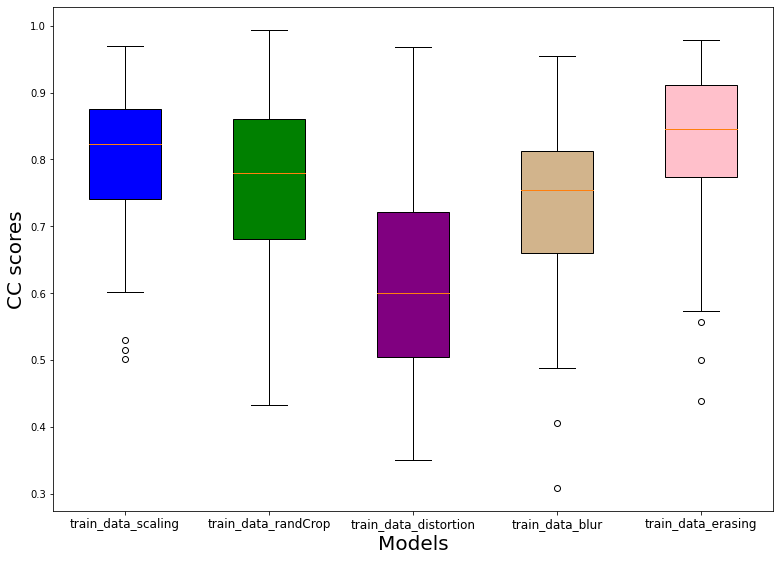

In [10]:
# try plotting some CC scores
tmp_list = []
for ds in CC_scores:
  # print(statistics.pstdev(CC_scores[ds]))
  tmp_list.append(CC_scores[ds])

fig = plt.figure(figsize =(10, 7))
ax = fig.add_axes([0, 1, 1, 1])
bp = ax.boxplot(tmp_list, notch=False, patch_artist=True)
ax.set_xticklabels(ds_names, fontsize = 12)
plt.ylabel('CC scores', fontsize = 20)
plt.xlabel('Models', fontsize = 20)
# plt.title("CC scores for each augmented CNN compared to baseline CNN", fontsize = 14)

colors = ['blue', 'green', 'purple', 'tan', 'pink']
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)
  
plt.show()
# plt.savefig('/content/gdrive/My Drive/Research/CC_boxplot.png')

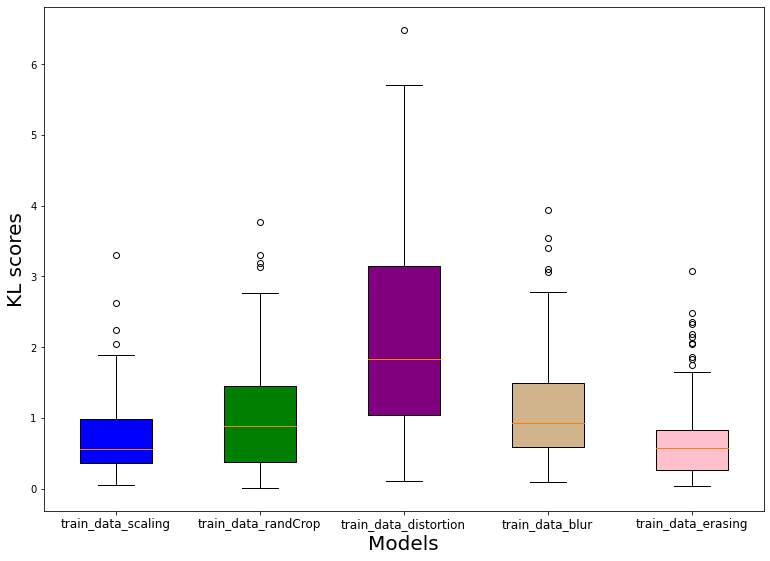

In [11]:
# plot some KL scores
tmp_list = []
for ds in KL_scores:
  tmp_list.append(KL_scores[ds])

fig = plt.figure(figsize =(10, 7))
ax = fig.add_axes([0, 1, 1, 1])
bp = ax.boxplot(tmp_list, notch=False, patch_artist=True)
ax.set_xticklabels(ds_names, fontsize = 12)
plt.ylabel('KL scores', fontsize = 20)
plt.xlabel('Models', fontsize = 20)
# plt.title("KL scores for each augmented CNN compared to baseline CNN", fontsize = 14)

colors = ['blue', 'green', 'purple', 'tan', 'pink']
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)

plt.savefig('/content/gdrive/My Drive/Research/KL_boxplot.png')
plt.show()

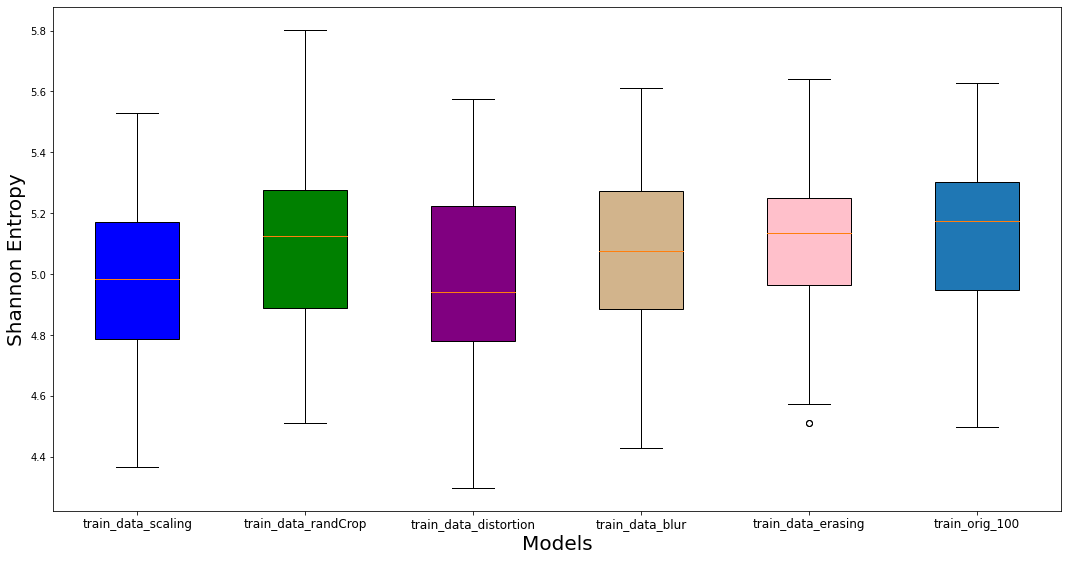

In [14]:
# plot entropies
tmp_list = []
for ds in shannon_scores:
  tmp_list.append(shannon_scores[ds])

fig = plt.figure(figsize =(14, 7))
ax = fig.add_axes([0, 1, 1, 1])
bp = ax.boxplot(tmp_list, notch=False, patch_artist=True)
ax.set_xticklabels(all_ds, fontsize = 12)
plt.ylabel('Shannon Entropy', fontsize = 20)
plt.xlabel('Models', fontsize = 20)
# plt.title("Shannon Entropy For all CNNs", fontsize = 14)

colors = ['blue', 'green', 'purple', 'tan', 'pink']
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)

# plt.savefig('/content/gdrive/My Drive/Research/shannon_entropy_boxplot.png')
plt.show()

In [ ]:
# Get statistics for CC and KL
for ds in KL_scores:
  print(ds)
  print("CC mean/std: ", np.mean(CC_scores[ds]), statistics.pstdev(CC_scores[ds]))
  print("KL mean/std: ", np.mean(KL_scores[ds]), statistics.pstdev(KL_scores[ds]))

train_data_scaling
CC mean/std:  0.8019852790487895 0.09978577393331461
KL mean/std:  0.7364989167826782 0.5568833301052227
train_data_randCrop
CC mean/std:  0.7675995000534515 0.12585597151985062
KL mean/std:  1.0507142576751718 0.8217917573289047
train_data_distortion
CC mean/std:  0.6199993962633079 0.1543284176612534
KL mean/std:  2.163091215348283 1.4361439445054278
train_data_blur
CC mean/std:  0.7370792631892141 0.11935266698581733
KL mean/std:  1.1509679005626854 0.7813209486727221
train_data_erasing
CC mean/std:  0.8280858653423125 0.10504134092164714
KL mean/std:  0.7292052816278995 0.6360839478282146


In [ ]:
# get statistics for shannon entropy
for ds in shannon_scores:
  print(ds)
  print("shannon_entropy mean/std: ", np.mean(shannon_scores[ds]), statistics.pstdev(shannon_scores[ds]))

train_data_scaling
shannon_entropy mean/std:  4.988827773498013 0.2832901413491627
train_data_randCrop
shannon_entropy mean/std:  5.082423266631725 0.28385566355420583
train_data_distortion
shannon_entropy mean/std:  4.9638455268648265 0.2910790072842243
train_data_blur
shannon_entropy mean/std:  5.063103668281972 0.25946539305156574
train_data_erasing
shannon_entropy mean/std:  5.102477248299377 0.23607763264766882
train_orig_100
shannon_entropy mean/std:  5.124648372822079 0.2808068746492659
